# Introduction

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load Data

In [ ]:
# Data folder path
data_dir = Path().parent / "data"
data_dir.mkdir(exist_ok=True)

In [30]:
# Read data files
target_col = 'Listening_Time_minutes'

train = pd.read_csv(data_dir / 'train.csv')
X, y = train.drop(columns=[target_col]), train[target_col]

test = pd.read_csv(data_dir / 'test.csv')
sample_submission = pd.read_csv(data_dir / 'sample_submission.csv')

# EDA

In [28]:
from sklearn.model_selection import train_test_split

In [31]:

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2, 
    stratify=train[target_col],
    random_state=42)


----------------------------------------
Stats:
----------------------------------------
Train Mean: 45.43906178961666
Train Std: 27.13859359937977
----------------------------------------
Validation Mean: 45.4307842822
Validation Std: 27.137244161427407


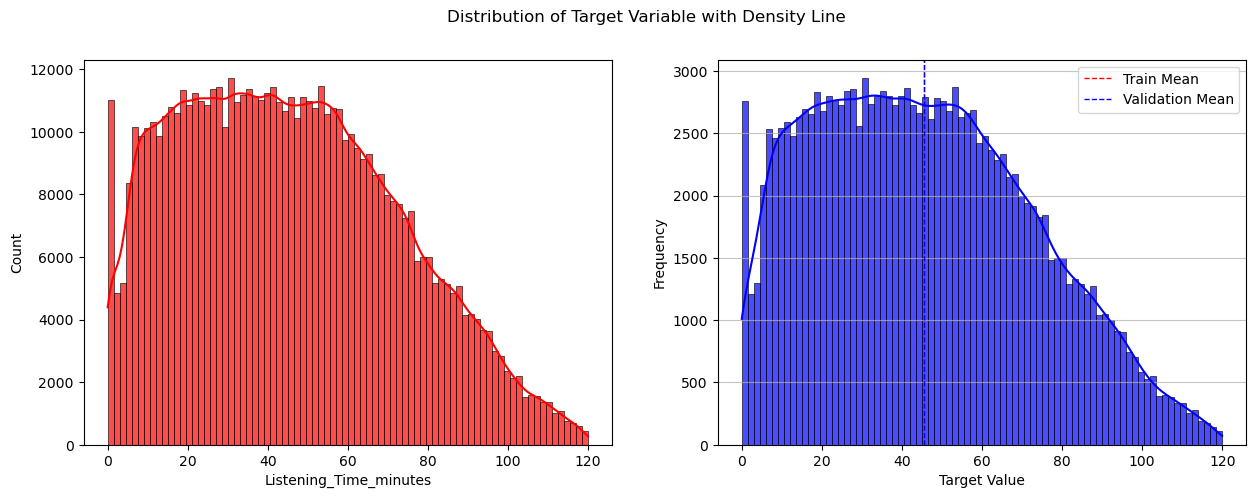

In [ ]:
# Normalize frequency
y_train_norm = y_train
y_val_norm = y_val

# Simple plotting of the target variable

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(y_train_norm, bins=80, kde=True, color='red', alpha=0.7, ax=ax[0])
plt.axvline(y_train_norm.mean(), color='red', linestyle='dashed', linewidth=1, label='Train Mean')
sns.histplot(y_val_norm, bins=80, kde=True, color='blue', alpha=0.7, ax=ax[1])
plt.axvline(y_val_norm.mean(), color='blue', linestyle='dashed', linewidth=1, label='Validation Mean')

fig.suptitle('Distribution of Target Variable with Density Line')

plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.legend()


print("--"*20)
print(f"Stats:")
print("--"*20)
print(f"Train Mean: {y_train_norm.mean()}")
print(f"Train Std: {y_train_norm.std()}")
print("--"*20)
print(f"Validation Mean: {y_val_norm.mean()}")
print(f"Validation Std: {y_val_norm.std()}")

Exploring correlation between target value and the rest of the columns

In [41]:
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

In [44]:
X_train.drop(columns = 'id', inplace=True)
X_val.drop(columns = 'id', inplace=True)

In [55]:
X_train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
473369,World Watch,Episode 41,32.29,News,62.95,Thursday,Afternoon,40.83,2.0,Positive
207987,Crime Chronicles,Episode 24,111.03,True Crime,52.71,Tuesday,Morning,81.59,1.0,Negative
126595,Style Guide,Episode 25,93.55,Lifestyle,67.35,Tuesday,Night,NaN,3.0,Neutral
519973,Global News,Episode 92,62.74,News,92.13,Friday,Night,41.07,2.0,Negative
78405,Money Matters,Episode 79,46.35,Business,39.05,Wednesday,Night,6.42,0.0,Positive


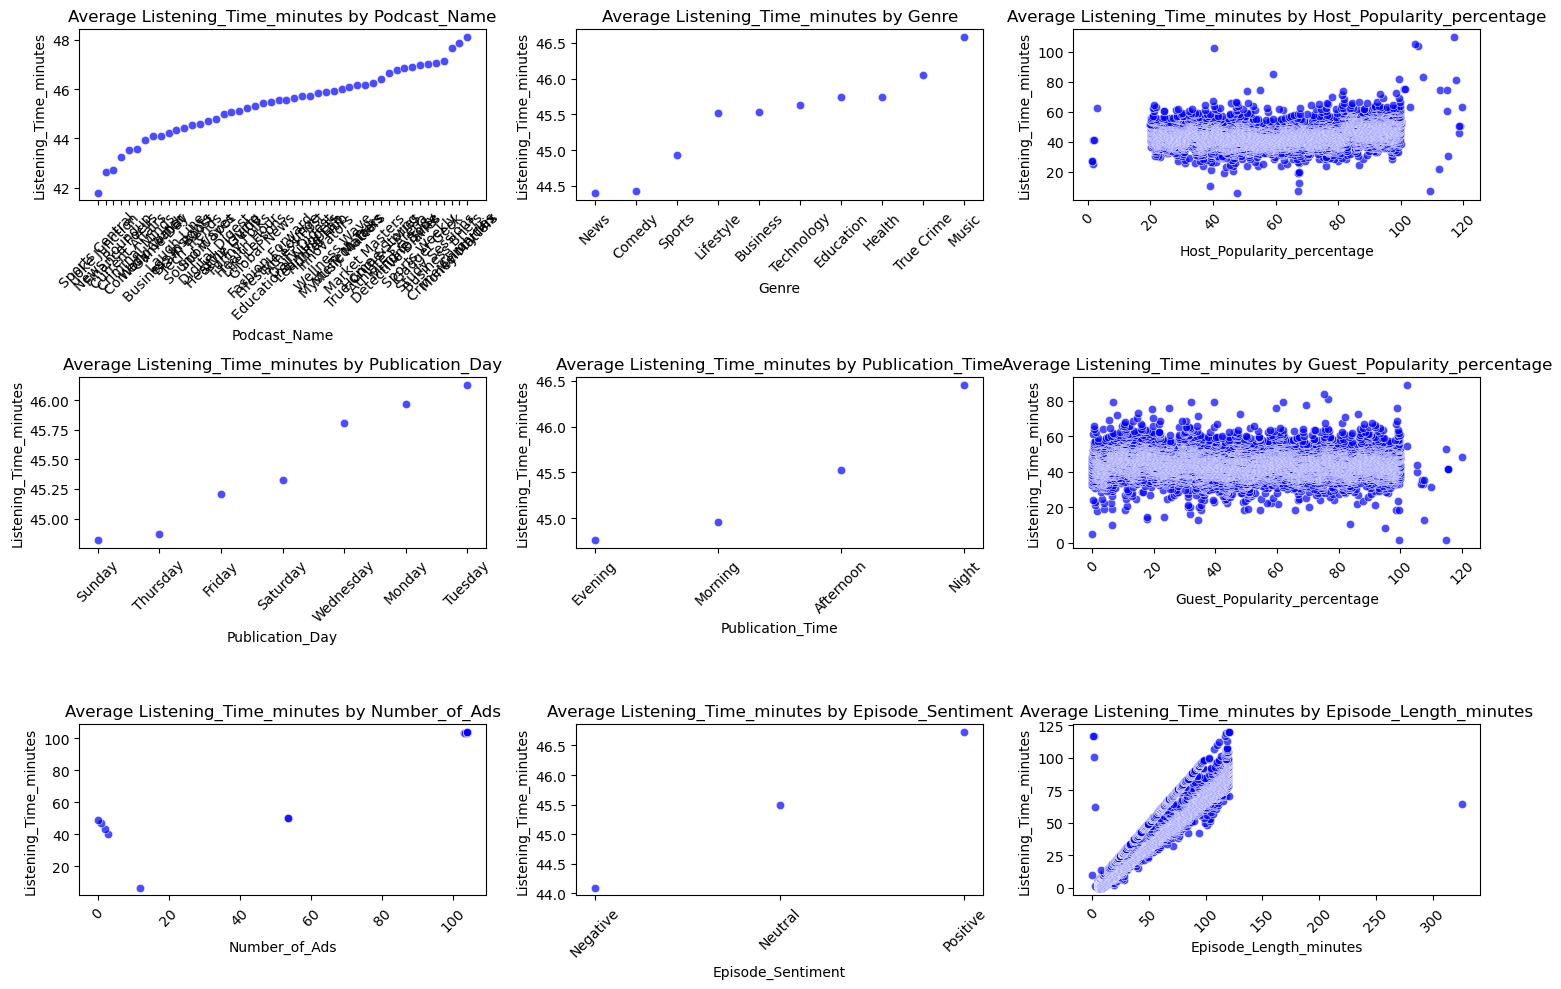

In [64]:
avg_target_per_category = ['Podcast_Name', 'Genre', 'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment', 'Episode_Length_minutes']

# Plot average target value per category
plt.figure(figsize=(15, 10))
for i, col in enumerate(avg_target_per_category):
    grouped = train.groupby(col)[target_col].mean().sort_values().reset_index()
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(data=grouped, x=col, y=target_col, color='blue', alpha=0.7)
    plt.title(f'Average {target_col} by {col}')
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.xticks(rotation=45)
    plt.tight_layout()